<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 4
*Pick one of the examples of the chapter that use the data of the book and replicate it in Python. Then, apply the steps in your own data.*

Los datos utilizados en este cuaderno están disponibles aquí: [datasets](https://drive.google.com/drive/folders/159GnBJQDxTY9oYqPBZzdNghyb4Gd9pDS?usp=sharing)

In [2]:
import numpy as np
import pandas as pd
import itertools
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,confusion_matrix, accuracy_score, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import scipy.stats
import statsmodels.api as sm
import statsmodels.tools.eval_measures as bias
import seaborn as sns
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Regresión logística en predicción de enfermedades cardiacas
A continuación repetiremos el ejemplo 4.4.2 de predicción de enfermedad cardiaca en Sudafrica **(South African Heart Disease)** del [libro](https://link.springer.com/book/10.1007/978-0-387-84858-7).

Iniciamos cargando los datos de entrenamiento y almacenamos en `y_train`:

In [3]:
## Procesamos datos de entrenamiento 
df = pd.read_csv('SAheart.csv')
df=df.assign(const=1)
print(df)
dfy = df['chd']  ## Outcome
dfx = df[['const','sbp','tobacco','ldl','adiposity','famhist','obesity','alcohol','age']]  ## Predictors

## Procesamos datos de prueba 
dfyt = df['chd']  ## Outcome
dfxt = df[['const','sbp','tobacco','ldl','adiposity','famhist','obesity','alcohol','age']]  ## Predictors

     row.names  sbp  tobacco    ldl  ...  alcohol  age  chd  const
0            1  160    12.00   5.73  ...    97.20   52    1      1
1            2  144     0.01   4.41  ...     2.06   63    1      1
2            3  118     0.08   3.48  ...     3.81   46    0      1
3            4  170     7.50   6.41  ...    24.26   58    1      1
4            5  134    13.60   3.50  ...    57.34   49    1      1
..         ...  ...      ...    ...  ...      ...  ...  ...    ...
457        459  214     0.40   5.98  ...     0.00   58    0      1
458        460  182     4.20   4.41  ...    18.72   52    1      1
459        461  108     3.00   1.59  ...    26.64   55    0      1
460        462  118     5.40  11.61  ...    23.97   40    0      1
461        463  132     0.00   4.82  ...     0.00   46    1      1

[462 rows x 12 columns]


In [4]:
X_train = dfx.to_numpy()   
X_train = sm.add_constant(X_train)
y_train = dfy.to_numpy()  
X_test  = dfxt.to_numpy()   
X_test = sm.add_constant(X_train)
y_test  = dfyt.to_numpy()   
#X_train.tofile('sample.csv',sep=',')

A continuación, obtenemos un modelo de predicción de los datos de entrenamiento usando regresión logística de la librería **statsmodels**. Como podemos ver algunas de las variables resultan ser no significativas con un valor P menor que 0.05. Tal es el caso de *alcohol, obesity, adiposity* y *sbp*. 

In [5]:
model = sm.Logit(dfy, dfx)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.522778
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      453
Method:                           MLE   Df Model:                            8
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                  0.1897
Time:                        06:23:01   Log-Likelihood:                -241.52
converged:                       True   LL-Null:                       -298.05
Covariance Type:            nonrobust   LLR p-value:                 8.931e-21
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9658      1.068     -3.715      0.000      -6.058      -1.873
sbp            0.0056      0.

De acuerdo con el libro, se aplicó una técnica de reducción de variables paso a paso **(Stepwise)** en el se encuentra un subconjunto de las variables que son suficientes para explicar el efecto conjunto de los predictores sobre la variable *chd*. El procedimiento descarta el coeficiente P menos significativo `pmenor` y el modelo se reajusta. Esto se hace repetidamente hasta que no se puedan eliminar más variables del modelo.
Los resultados obtenidos en la tabla coinciden con los del libro.


In [6]:
# Se ordenan los valores p y se selecciona el más pequeño
p_values = results.pvalues.sort_values(ascending = False)
pmenor = p_values.head(1)

print("menorpi.item() ", pmenor.item())

while pmenor.item() > 0.01:
    print(pmenor.index.tolist())
    dfx = dfx.drop(pmenor.index.tolist(), axis=1)
    model = sm.Logit(dfy, dfx)
    model = model.fit()
    # Se ordenan los valores p y se selecciona el más pequeño
    p_values = model.pvalues.sort_values(ascending = False)
    pmenor = p_values.head(1)

print(model.summary())

menorpi.item()  0.9062256410652616
['alcohol']
Optimization terminated successfully.
         Current function value: 0.522793
         Iterations 6
['adiposity']
Optimization terminated successfully.
         Current function value: 0.522936
         Iterations 6
['sbp']
Optimization terminated successfully.
         Current function value: 0.524131
         Iterations 6
['obesity']
Optimization terminated successfully.
         Current function value: 0.525372
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      457
Method:                           MLE   Df Model:                            4
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                  0.1856
Time:                        06:23:02   Log-Likelihood:                -242.72
converged:                       True

Finalmente, evaluamos el desempeño del modelo calculando la exactitud y la matriz de confusión.

In [7]:
yhat       = model.predict(dfx)
prediction = list(map(round, yhat))

# Calculamos la matriz de confusión
cm = confusion_matrix(dfy, prediction)
print ("Confusion Matrix : \n", cm)
 
# Exactitud del modelo
print('Test accuracy = ', accuracy_score(dfy, prediction))

Confusion Matrix : 
 [[254  48]
 [ 76  84]]
Test accuracy =  0.7316017316017316


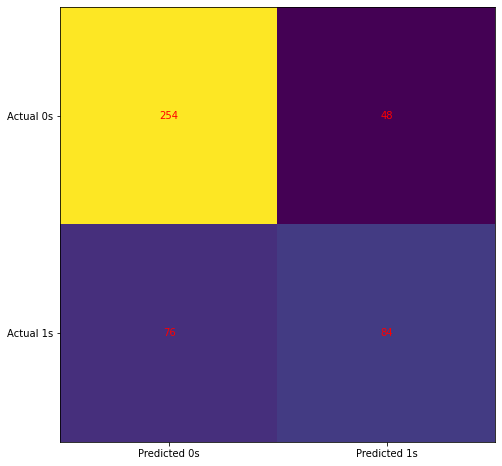

In [8]:
def confussion(cm):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()
confussion(cm)

Otra manera de calcular una regresión logistica es con la librería **sklearn** tal como se muestra a continuación.

In [9]:
##https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
logisticRegr.predict(X_test[0].reshape(1,-1))
logisticRegr.predict(X_test[0:10])
predictions = logisticRegr.predict(X_test)
error = y_test - predictions
# Use score method to get accuracy of model
score = logisticRegr.score(X_test, y_test)
parametros=logisticRegr.get_params(deep=False)
print(score)

0.7229437229437229


### Rgresión logística aplicada a clasificación de regiones de consumo de electricidad.



#https://www-datasklr-com.translate.goog/select-classification-methods/linear-and-quadratic-discriminant-analysis?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=en-US&_x_tr_pto=wapp

In [10]:
import warnings
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [11]:
## Procesamos datos de entrenamiento 
df = pd.read_csv('r_Regiones_100s_train.csv')
df=df.assign(const=1)
dfy = df['Clase'] 
dfx = df[['GenTer','GenHid','GenRE','GenNP','GenTot','Demanda','PotInt','Perdidas','PrecioMarginal']]  ## Predictors
X = dfx.to_numpy() 
#X = sm.add_constant(X) para agregar una constante en uno
y = dfy.to_numpy()

In [12]:
#Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 5)

In [22]:
LDA_model_default = LinearDiscriminantAnalysis()
LDA_model_default.fit(X_test, y_test)
y_pred_LDA_default =LDA_model_default.predict(X_test)
print(y_pred_LDA_default)
y_pred_LDA_default.tofile('sample.csv',sep=',')
y_test.tofile('y.csv',sep=',')
score = logisticRegr.score(X_test, y_test)
parametros = logisticRegr.get_params(deep=False)
print(score)

[16 67  2 ... 51 13 12]
0.0168681219556197
